# Stats

> Statistical functions for portfolio analysis

In [ ]:
#| default_exp stats

In [ ]:
#| export
#| echo: false
from nbdev.showdoc import *
from warnings import warn
import pandas as pd
import numpy as np
from math import ceil, sqrt
from scipy.stats import (
    norm, linregress
)

import hypersheets.utils as _utils

In [ ]:
#| hide
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi'] = 300

In [ ]:
#| export
def compsum(returns):
    """Calculates cumulative compounded returns up to each day, for series of daily returns"""
    return returns.add(1).cumprod() -1

In [ ]:
#| eval: true
returns = pd.Series(np.array([0.03, 0.01, 0.05, -0.01, -0.03]))
compsum(returns)

0    0.030000
1    0.040300
2    0.092315
3    0.081392
4    0.048950
dtype: float64

In [ ]:
#| export
def comp(returns):
    """Calculates total compounded return, for series of daily returns"""
    return returns.add(1).prod() -1

In [ ]:
#| eval: true
returns = pd.Series(np.array([0.03, 0.01, 0.05, -0.01, -0.03]))

comp(returns)

0.048950094500000096

In [ ]:
#| export

def distribution(returns, compounded=True, prepare_returns=False):
    """Show the returns and outlier values based on IQR from a series of returns. Outliers are those more than 1.5 times the IQR from the Q1/Q3"""
    def get_outliers(data):
        # https://datascience.stackexchange.com/a/57199
        Q1 = data.quantile(0.25)
        Q3 = data.quantile(0.75)
        IQR = Q3 - Q1  # IQR is interquartile range.
        filtered = (data >= Q1 - 1.5 * IQR) & (data <= Q3 + 1.5 * IQR)
        return {
            "values": data.loc[filtered].tolist(),
            "outliers": data.loc[~filtered].tolist(),
        }

    if isinstance(returns, pd.DataFrame):
        warn("Pandas DataFrame was passed (Series expeted). "
             "Only first column will be used.")
        returns = returns.copy()
        returns.columns = map(str.lower, returns.columns)
        if len(returns.columns) > 1 and 'close' in returns.columns:
            returns = returns['close']
        else:
            returns = returns[returns.columns[0]]

    apply_fnc = comp if compounded else np.sum
    daily = returns.dropna()

    if prepare_returns:
        daily = _utils.prepare_returns(daily)

    return {
        "Daily": get_outliers(daily),
        "Weekly": get_outliers(daily.resample('W-MON').apply(apply_fnc)),
        "Monthly": get_outliers(daily.resample('M').apply(apply_fnc)),
        "Quarterly": get_outliers(daily.resample('Q').apply(apply_fnc)),
        "Yearly": get_outliers(daily.resample('A').apply(apply_fnc))
    }

In [ ]:
#| hide
returns = _utils.download_returns('SPY', '5y')

distribution(returns)

{'Daily': {'values': [0.0,
   0.002140309343829472,
   0.0011864335447282492,
   0.005925072259622022,
   -0.0011388707315118651,
   -0.0016510947474621673,
   0.0026382109352180994,
   0.0015711730143017633,
   -0.0014902044243585433,
   0.0012173854103250115,
   0.0013336933503167447,
   0.0007049409502042359,
   0.0009786589092521947,
   0.00027368635426761045,
   0.0051605242549190855,
   -0.003889406844114318,
   0.0017571968785068393,
   -0.004950148213444194,
   0.0012926414208400683,
   0.008176268571229661,
   -0.0037251756578240425,
   0.0015579440086994634,
   0.0013220243830569522,
   0.0003884312955122482,
   0.003338760222701964,
   0.0015475676314526954,
   -0.0006953743314047633,
   0.0017010438837437025,
   -0.0036279121225516464,
   -0.0003097977432940935,
   0.000929810096982564,
   -0.0023223015160839244,
   -0.005005483295851154,
   0.0085009821544475,
   -0.0029386005124821812,
   0.0017062582858475839,
   0.006542712515201332,
   -0.0008844496496226428,
   0.0023

In [ ]:
#| export
def expected_return(returns, aggregate=None, compounded=True,
                    prepare_returns=True):
    """
    Returns the expected geometric return for a given period
    by calculating the geometric holding period return
    """
    # if prepare_returns:
    #     returns = _utils.prepare_returns(returns)
    # returns = _utils.aggregate_returns(returns, aggregate, compounded)
    return np.product(1 + returns) ** (1 / len(returns)) - 1

The expected geometric return is:
$$ \left(\prod\limits_{i=1}^{n}(p_{i})\right)^{(1/n)} -1$$

where $p_{i}$ is 1+ the daily return: $p_{i}=\frac{v_{i}}{v_{i-1}}=1+r_{i}$, where $v_{i}$ and $r_{i}$ are value and return of the asset on day $i$ respectively

In [ ]:
#| eval: true
returns = pd.Series(np.array([0.03, 0.01, 0.05, -0.01, -0.03]))
expected_return(returns, aggregate=None, compounded=True,
                    prepare_returns=True)

0.009603773872040255

In [ ]:
#| export
def geometric_mean(retruns, aggregate=None, compounded=True):
    """Shorthand for expected_return()"""
    return expected_return(retruns, aggregate, compounded)


def ghpr(retruns, aggregate=None, compounded=True):
    """Shorthand for expected_return()"""
    return expected_return(retruns, aggregate, compounded)

In [ ]:
#| export
def outliers(returns, quantile=.95):
    """Returns series of outliers: all values greater than the quantile"""
    return returns[returns > returns.quantile(quantile)].dropna(how='all')

In [ ]:
#| eval: true
returns = pd.Series(np.arange(1, 101, 1))
outliers(returns, quantile=.95)

95     96
96     97
97     98
98     99
99    100
dtype: int32

In [ ]:
#| export
def remove_outliers(returns, quantile=.95):
    """Returns series of returns without the outliers on the top end"""
    return returns[returns < returns.quantile(quantile)]

In [ ]:
#| eval: true
returns = pd.Series(np.arange(1, 101, 1))
remove_outliers(returns, quantile=.95).tail(10) # the range goes from [1,100] to [1,95]

85    86
86    87
87    88
88    89
89    90
90    91
91    92
92    93
93    94
94    95
dtype: int32

In [ ]:
#| export
def best(returns, aggregate=None, compounded=True, prepare_returns=False):
    """Returns the best day/month/week/quarter/year's return"""
    if prepare_returns:
        returns = _utils.prepare_returns(returns)
    return _utils.aggregate_returns(returns, aggregate, compounded).max()

In [ ]:
#| eval: true
returns = _utils.download_returns('SPY', '5y')
best(returns)
#best(returns)

0.09060315805687602

In [ ]:
#| export
def worst(returns, aggregate=None, compounded=True, prepare_returns=False):
    """Returns the worst day/month/week/quarter/year's return"""
    if prepare_returns:
        returns = _utils.prepare_returns(returns)
    return _utils.aggregate_returns(returns, aggregate, compounded).min()

In [ ]:
#| eval: true
returns = _utils.download_returns('SPY', '5y')
worst(returns)
#best(returns)

-0.10942352331745997

In [ ]:
#| export
def consecutive_wins(returns, aggregate=None, compounded=True,
                     prepare_returns=False):
    """Returns the maximum consecutive wins by day/month/week/quarter/year"""
    if prepare_returns:
        returns = _utils.prepare_returns(returns)
    returns = _utils.aggregate_returns(returns, aggregate, compounded) > 0
    return _utils._count_consecutive(returns).max()

In [ ]:
#| eval: true
returns = _utils.download_returns('SPY', '5y')
consecutive_wins(returns)
#best(returns)

11

In [ ]:
#| export
def consecutive_losses(returns, aggregate=None, compounded=True,
                       prepare_returns=False):
    """
    Returns the maximum consecutive losses by
    day/month/week/quarter/year
    """
    if prepare_returns:
        returns = _utils.prepare_returns(returns)
    returns = _utils.aggregate_returns(returns, aggregate, compounded) < 0
    return _utils._count_consecutive(returns).max()

In [ ]:
#| eval: true
returns = _utils.download_returns('SPY', '5y')
consecutive_losses(returns)
#best(returns)

8

In [ ]:
#| export
def _exposure(ret):
    """Internal method for exposure"""
    ex = len(ret[(~np.isnan(ret)) & (ret != 0)]) / len(ret)
    return ceil(ex * 100) / 100

In [ ]:
#| export
def exposure(returns, prepare_returns=False):
    """Returns the market exposure time (returns != 0)"""
    if prepare_returns:
        returns = _utils._prepare_returns(returns)
    if isinstance(returns, pd.DataFrame):
        _df = {}
        for col in returns.columns:
            _df[col] = _exposure(returns[col])
        return pd.Series(_df)
    ex = len(returns[(~np.isnan(returns)) & (returns != 0)]) /len(returns)
    return ceil(ex * 100) / 100 

In [ ]:
#| eval: true
returns = _utils.download_returns('SPY', '5y')
exposure(returns)


1.0

In [ ]:
#| export
#| echo: false
def _win_rate(series):
    """Internal method for win_rate"""
    try:
            return len(series[series > 0]) / len(series[series != 0])
    except Exception:
        return 0.

In [ ]:
#| export
def win_rate(returns, aggregate=None, compounded=True, prepare_returns=False):
    """Calculates the win ratio for a period: (number of winning days)/(number of days in market)"""

    if prepare_returns:
        returns = _utils.prepare_returns(returns)
    if aggregate:
        returns = _utils.aggregate_returns(returns, aggregate, compounded)

    if isinstance(returns, pd.DataFrame):
        _df = {}
        for col in returns.columns:
            _df[col] = _win_rate(returns[col])

        return pd.Series(_df)

    return _win_rate(returns)

In [ ]:
#| eval: true
returns = _utils.download_returns('SPY', '5y')
win_rate(returns)

0.5542264752791068

In [ ]:
#| export
def avg_return(returns, aggregate=None, compounded=True, prepare_returns=False):
    """Calculates the average return/trade return for a period"""
    if prepare_returns:
        returns = _utils.prepare_returns(returns)
    if aggregate:
        returns = _utils.aggregate_returns(returns, aggregate, compounded)
    return returns[returns != 0].dropna().mean()


In [ ]:
#| eval: true
returns = _utils.download_returns('SPY', '5y')
avg_return(returns)

0.0004451419089322777

In [ ]:
#| export
def avg_win(returns, aggregate=None, compounded=True, prepare_returns=False):
    """
    Calculates the average winning
    return/trade return for a period
    """
    if prepare_returns:
        returns = _utils.prepare_returns(returns)
    if aggregate:
        returns = _utils.aggregate_returns(returns, aggregate, compounded)
    return returns[returns > 0].dropna().mean()

In [ ]:
#| eval: true
returns = _utils.download_returns('SPY', '5y')
avg_win(returns)

0.008044224938256789

In [ ]:
#| export
def avg_loss(returns, aggregate=None, compounded=True, prepare_returns=False):
    """
    Calculates the average low if
    return/trade return for a period
    """
    if prepare_returns:
        returns = _utils._prepare_returns(returns)
    if aggregate:
        returns = _utils.aggregate_returns(returns, aggregate, compounded)
    return returns[returns < 0].dropna().mean()

In [ ]:
#| eval: true
returns = _utils.download_returns('SPY', '5y')
avg_loss(returns)

-0.009002736188760357

In [ ]:
#| export
def volatility(returns, periods=252, annualize=True, prepare_returns=False):
    """Calculates the volatility of returns for a period"""
    if prepare_returns:
        returns = _utils.prepare_returns(returns)
    std = returns.std()
    if annualize:
        return std * np.sqrt(periods)

    return std

Calculate volatility as $\text{vol.}=\sigma\sqrt{T}$ where $\sigma$ is the standard deviations of returns and $T$ the number of periods in the time horizon 

In [ ]:
#| eval: true
returns = _utils.download_returns('SPY', '5y')
volatility(returns)

0.20844063908238844

In [ ]:
#| export
def rolling_volatility(returns, rolling_period=126, periods_per_year=252,
                       prepare_returns=False):
    """Create time series of rolling volatility"""
    if prepare_returns:
        returns = _utils.prepare_returns(returns, rolling_period)

    return returns.rolling(rolling_period).std() * np.sqrt(periods_per_year)

In [ ]:
#| eval: true
returns = _utils.download_returns('SPY', '1y')
rolling_volatility(returns).tail(10)

Date
2022-09-16    0.248680
2022-09-19    0.248414
2022-09-20    0.248865
2022-09-21    0.249286
2022-09-22    0.248944
2022-09-23    0.248828
2022-09-26    0.248951
2022-09-27    0.248649
2022-09-28    0.249690
2022-09-29    0.251102
Name: Close, dtype: float64

In [ ]:
#| export
def implied_volatility(returns, periods=252, annualize=False):
    """Calculates the implied volatility of returns for a period"""
    logret = _utils.to_log_returns(returns)
    if annualize:
        return logret.rolling(periods).std() * _np.sqrt(periods)
    return logret.std()


Implied volatility is defined here as the standard deviation of the log returns. This works under the assumption that returns are lognormally distributed and so the log of returns is a normal distribution.

In [ ]:
#| eval: true
returns = _utils.download_returns('SPY', '1y')
implied_volatility(returns)

0.013801893088772903

In [ ]:
#| export
def autocorr_penalty(returns, prepare_returns=False):
    """Metric to account for auto correlation"""
    if prepare_returns:
        returns = _utils.prepare_returns(returns)

    returns = returns.dropna() # NA values break the

    if isinstance(returns, pd.DataFrame):
        returns = returns[returns.columns[0]]

    # returns.to_csv('/Users/ran/Desktop/test.csv')
    num = len(returns)
    coef = np.abs(np.corrcoef(returns[:-1], returns[1:])[0, 1])
    corr = [((num - x)/num) * coef ** x for x in range(1, num)]
    return np.sqrt(1 + 2 * np.sum(corr))

In [ ]:
#| eval: true
returns = _utils.download_returns('SPY', '5y')
autocorr_penalty(returns)

1.1893156409496177

In [ ]:
#| export
def sharpe(returns, rf=0., periods=252, annualize=True, smart=False, prepare_returns=False):
    """
    Calculates the sharpe ratio of access returns
    If rf is non-zero, you must specify periods.
    In this case, rf is assumed to be expressed in yearly (annualized) terms
    Args:
        * returns (Series, DataFrame): Input return series
        * rf (float): Risk-free rate expressed as a yearly (annualized) return
        * periods (int): Freq. of returns (252/365 for daily, 12 for monthly)
        * annualize: return annualize sharpe?
        * smart: return smart sharpe ratio
    """
    if rf != 0 and periods is None:
        raise Exception('Must provide periods if rf != 0')

    if prepare_returns:
        returns = _utils.prepare_returns(returns, rf, periods)
    returns = _utils.to_excess_returns(returns, rf, periods)
    divisor = returns.std(ddof=1)
    if smart:
        # penalize sharpe with auto correlation
        divisor = divisor * autocorr_penalty(returns)
    res = returns.mean() / divisor

    if annualize:
        return res * np.sqrt(
            1 if periods is None else periods)

    return res

In [ ]:
#| eval: true
returns = _utils.download_returns('SPY', '5y')
sharpe(returns)

0.5364553566622334

In [ ]:
#| export
def smart_sharpe(returns, rf=0., periods=252, annualize=True):
    """Sharpe ratio, penalised with autocorrelation penalty"""
    return sharpe(returns, rf, periods, annualize, True)

In [ ]:
#| eval: true
returns = _utils.download_returns('SPY', '5y')
smart_sharpe(returns)

0.4510622023704182

In [ ]:
#| export
def rolling_sharpe(returns, rf=0., rolling_period=126,
                   annualize=True, periods_per_year=252,
                   prepare_returns=False):

    """Calculate rolling Sharpe ratio over a period"""
    if rf != 0 and rolling_period is None:
        raise Exception('Must provide periods if rf != 0')

    if prepare_returns:
        returns = _utils.prepare_returns(returns, rf, rolling_period)

    returns = _utils.to_excess_returns(returns, rf, rolling_period)

    res = returns.rolling(rolling_period).mean() / \
        returns.rolling(rolling_period).std()

    if annualize:
        res = res * np.sqrt(
            1 if periods_per_year is None else periods_per_year)

    return res

In [ ]:
#| eval: true
returns = _utils.download_returns('SPY', '5y')
rolling_sharpe(returns).tail(10)

Date
2022-09-16   -0.864632
2022-09-19   -0.891301
2022-09-20   -0.979586
2022-09-21   -1.211758
2022-09-22   -1.177445
2022-09-23   -1.433826
2022-09-26   -1.551825
2022-09-27   -1.631454
2022-09-28   -1.566138
2022-09-29   -1.674526
Name: Close, dtype: float64

In [ ]:
#| export
def sortino(returns, rf=0, periods=252, annualize=True, smart=False,
                   prepare_returns=False):
    """
    Calculates the sortino ratio of access returns
    If rf is non-zero, you must specify periods.
    In this case, rf is assumed to be expressed in yearly (annualized) terms
    Calculation is based on this paper by Red Rock Capital
    http://www.redrockcapital.com/Sortino__A__Sharper__Ratio_Red_Rock_Capital.pdf
    """
    if rf != 0 and periods is None:
        raise Exception('Must provide periods if rf != 0')

    if prepare_returns:
        returns = _utils.prepare_returns(returns, rf, periods)

    returns = _utils.to_excess_returns(returns, rf, periods)

    downside = np.sqrt((returns[returns < 0] ** 2).sum() / len(returns))

    if smart:
        # penalize sortino with auto correlation
        downside = downside * autocorr_penalty(returns)

    res = returns.mean() / downside

    if annualize:
        return res * np.sqrt(
            1 if periods is None else periods)

    return res

Calculates Sortino ratio as $\frac{\text{Expected Excess Return}}{\text{Downside Deviation}}$ where for $n$ periods the Downside deviation is $\sqrt{\frac{\sum d^{2}}{n}}$ where $d$ is an excess return less than 0, and the expected excess return is the mean excess return, and annualised

In [ ]:
#| eval: true
returns = _utils.download_returns('SPY', '5y')
sortino(returns)

0.7310777239511432

In [ ]:
#| export
def smart_sortino(returns, rf=0, periods=252, annualize=True):
    """Calculates Smart Sortino ratio, adding an autocorrelation penalty"""
    return sortino(returns, rf, periods, annualize, True)

In [ ]:
#| eval: true
returns = _utils.download_returns('SPY', '5y')
smart_sortino(returns)

0.6147043287347095

In [ ]:
def adjusted_sortino(returns, rf=0, periods=252, annualize=True, smart=False):
    """
    Jack Schwager's version of the Sortino ratio allows for
    direct comparisons to the Sharpe. See here for more info:
    https://archive.is/wip/2rwFW
    """
    data = sortino(
        returns, rf, periods=periods, annualize=annualize, smart=smart)
    return data / sqrt(2)

The adjusted sortino is defined as $\text{Adj. Sortino}=\text{Sortino}/\sqrt{2}$

In [ ]:
#| eval: true
returns = _utils.download_returns('SPY', '5y')
adjusted_sortino(returns)

0.5169498730432484

In [ ]:
#| export
def rolling_sortino(returns, rf=0, rolling_period=126, annualize=True,
                    periods_per_year=252, **kwargs):
    if rf != 0 and rolling_period is None:
        raise Exception('Must provide periods if rf != 0')

    if kwargs.get("prepare_returns", True):
        returns = _utils.prepare_returns(returns, rf, rolling_period)
    
    returns = _utils.to_excess_returns(returns, rf, rolling_period)

    downside = returns.rolling(rolling_period).apply(
        lambda x: (x.values[x.values < 0]**2).sum()) / rolling_period

    res = returns.rolling(rolling_period).mean() / np.sqrt(downside)
    if annualize:
        res = res * np.sqrt(
            1 if periods_per_year is None else periods_per_year)
    return res

In [ ]:
#| eval: true
returns = _utils.download_returns('SPY', '5y')
rolling_sortino(returns).tail(10)

Date
2022-09-16   -1.119173
2022-09-19   -1.152463
2022-09-20   -1.264410
2022-09-21   -1.554069
2022-09-22   -1.511805
2022-09-23   -1.826545
2022-09-26   -1.972788
2022-09-27   -2.071153
2022-09-28   -1.996554
2022-09-29   -2.124861
Name: Close, dtype: float64

In [ ]:
#| export
def skew(returns, prepare_returns=False):
    """
    Calculates returns' skewness
    (the degree of asymmetry of a distribution around its mean)
    """
    if prepare_returns:
        returns = _utils.prepare_returns(returns)
    return returns.skew()

The skew is defined as $\text{Skew}(X)=\frac{E[(X-\mu)^{3}]}{E[(X-\mu)^{2}]^{3/2}}=\frac{\mu_{3}}{\sigma^{3}}$, where $\mu$ is mean, $\sigma$ stadard deviation and $\mu_{3}$, third moment of inertia.

In [ ]:
#| eval: true
returns = _utils.download_returns('SPY', '5y')
skew(returns)

-0.6567130752131589

In [ ]:
#| export
def kurtosis(returns, prepare_returns=False):
    """
    Calculates returns' kurtosis
    (the degree to which a distribution peak compared to a normal distribution)
    """
    if prepare_returns:
        returns = _utils.prepare_returns(returns)
    return returns.kurtosis()

The kurtosis is defined as $\text{Kurt}(X)=\frac{E[(X-\mu)^{4}]}{E[(X-\mu)^{2}]^{2}}=\frac{\mu_{4}}{\sigma^{2}}$, where $\mu$ is mean, $\sigma$ stadard deviation and $\mu_{4}$, fourth moment of inertia. A measure of 'tailed': higher kurtosis means fatter tails.

In [ ]:
#| eval: true
returns = _utils.download_returns('SPY', '5y')
kurtosis(returns)

11.996182480024226

<AxesSubplot:ylabel='Frequency'>

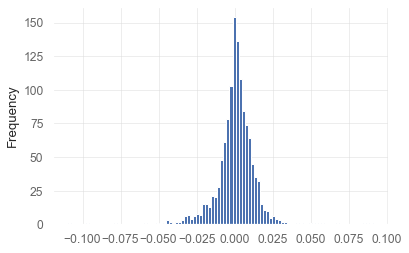

In [ ]:
#| echo: false
#| output: asis
returns = _utils.download_returns('SPY', '5y')
returns.plot.hist(bins=100)
plt.show()

In [ ]:
#| export
# check logic for this
def probabilistic_ratio(series, rf=0., base="sharpe", periods=252, annualize=False, smart=False):

    if base.lower() == "sharpe":
        base = sharpe(series, periods=periods, annualize=False, smart=smart)
    elif base.lower() == "sortino":
        base = sortino(series, periods=periods, annualize=False, smart=smart)
    elif base.lower() == "adjusted_sortino":
        base = adjusted_sortino(series, periods=periods,
                                annualize=False, smart=smart)
    else:
        raise Exception(
            '`metric` must be either `sharpe`, `sortino`, or `adjusted_sortino`')
    skew_no = skew(series, prepare_returns=False)
    kurtosis_no = kurtosis(series, prepare_returns=False)

    n = len(series)

    sigma_sr = np.sqrt((1 + (0.5 * base ** 2) - (skew_no * base) +
                       (((kurtosis_no - 3) / 4) * base ** 2)) / (n - 1))

    ratio = (base - rf) / sigma_sr
    psr = norm.cdf(ratio)

    if annualize:
        return psr * (252 ** 0.5)
    return psr


In [ ]:
#| export
def probabilistic_sharpe_ratio(series, rf=0., periods=252, annualize=False, smart=False):
    """The probabilistic Sharpe Ratio"""
    return probabilistic_ratio(series, rf, base="sharpe", periods=periods,
                               annualize=annualize, smart=smart)

In [ ]:
#| eval: true
returns = _utils.download_returns('SPY', '5y')
probabilistic_sharpe_ratio(returns)

0.8816407449051655

In [ ]:
#| export
def probabilistic_sortino_ratio(series, rf=0., periods=252, annualize=False, smart=False):
    """The probabilistic Sortino Ratio"""
    return probabilistic_ratio(series, rf, base="sortino", periods=periods,
                               annualize=annualize, smart=smart)

In [ ]:
#| eval: true
returns = _utils.download_returns('SPY', '5y')
probabilistic_sortino_ratio(returns)

0.9456555568118186

In [ ]:
#| export
def probabilistic_adjusted_sortino_ratio(series, rf=0., periods=252, annualize=False, smart=False):
    """The probabilistic adj. Sortino Ratio"""
    return probabilistic_ratio(series, rf, base="adjusted_sortino", periods=periods,
                               annualize=annualize, smart=smart)

In [ ]:
#| eval: true
returns = _utils.download_returns('SPY', '5y')
probabilistic_adjusted_sortino_ratio(returns)

0.8730193107071486

In [ ]:
#| export
def omega(returns, rf=0.0, required_return=0.0, periods=252, **kwargs):
    """
    Determines the Omega ratio of a strategy.
    See https://en.wikipedia.org/wiki/Omega_ratio for more details.
    """
    if len(returns) < 2:
        return np.nan

    if required_return <= -1:
        return np.nan

    if kwargs.get("prepare_returns", True):
        returns = _utils.prepare_returns(returns, rf, periods)
    
    returns = _utils.to_excess_returns(returns, rf, periods)

    if periods == 1:
        return_threshold = required_return
    else:
        return_threshold = (1 + required_return) ** (1. / periods) - 1

    returns_less_thresh = returns - return_threshold
    numer = returns_less_thresh[returns_less_thresh > 0.0].sum().values[0]
    denom = -1.0 * \
        returns_less_thresh[returns_less_thresh < 0.0].sum().values[0]

    if denom > 0.0:
        return numer / denom

    return np.nan


This is broken

In [ ]:
#| eval: true
returns = _utils.download_returns('SPY', '5y')
#omega(returns, 0.01)

In [ ]:
#| export
def gain_to_pain_ratio(returns, rf=0, resolution="D", **kwargs):
    """
    Jack Schwager's GPR. See here for more info:
    https://archive.is/wip/2rwFW
    """
    if kwargs.get("prepare_returns", True):
        returns = _utils.prepare_returns(returns, rf)
    returns = returns.resample(resolution).sum()
    downside = abs(returns[returns < 0].sum())
    return returns.sum() / downside


This seems to be wrong

In [ ]:
#| eval: true
returns = _utils.download_returns('SPY', '5y')
gain_to_pain_ratio(returns, 10)

0.11091999229680034

In [ ]:
#| export
def cagr(returns, rf=0., compounded=True, **kwargs):
    """
    Calculates the communicative annualized growth return
    (CAGR%) of access returns
    If rf is non-zero, you must specify periods?.
    In this case, rf is assumed to be expressed in yearly (annualized) terms
    """
    if kwargs.get("prepare_returns", True):
        returns = _utils.prepare_returns(returns, rf)
    total = returns.copy()
    if compounded:
        total = comp(total)
    else:
        total = np.sum(total)

    years = (returns.index[-1] - returns.index[0]).days / 365.

    res = abs(total + 1.0) ** (1.0 / years) - 1

    if isinstance(returns, pd.DataFrame):
        res = pd.Series(res)
        res.index = returns.columns

    return res

Check

In [ ]:
#| eval: true
returns = _utils.download_returns('SPY', '5y')
cagr(returns, 10)

0.09407550605477089

In [ ]:
#| export
def rar(returns, rf=0., **kwargs):
    """
    Calculates the risk-adjusted return of access returns
    (CAGR / exposure. takes time into account.)
    If rf is non-zero, you must specify periods.
    In this case, rf is assumed to be expressed in yearly (annualized) terms
    """
    if kwargs.get("prepare_returns", True):
        returns = _utils.prepare_returns(returns, rf)
    return cagr(returns) / exposure(returns)

Check if this should be excess return

In [ ]:
#| eval: true
returns = _utils.download_returns('SPY', '5y')
rar(returns)

0.09407549161897544

In [ ]:
#| export
def max_drawdown(returns):
    """Calculates the maximum drawdown"""
    prices = _utils.prepare_prices(returns) # convert returns to prices
    return (prices / prices.expanding(min_periods=0).max()).min() - 1

In [ ]:
#| eval: true
returns = _utils.download_returns('SPY', '5y')
max_drawdown(returns)

-0.3371726193896011

In [ ]:
#| export
def to_drawdown_series(returns):
    """Convert returns series to drawdown series"""
    prices = _utils.prepare_prices(returns) # convert returns to prices
    dd = prices / np.maximum.accumulate(prices) - 1.
    return dd.replace([np.inf, -np.inf, -0], 0)

In [ ]:
#| eval: true
returns = _utils.download_returns('SPY', '5y')
to_drawdown_series(returns).tail(10)

Date
2022-09-16   -0.183555
2022-09-19   -0.177223
2022-09-20   -0.186668
2022-09-21   -0.200855
2022-09-22   -0.207568
2022-09-23   -0.220845
2022-09-26   -0.228553
2022-09-27   -0.230522
2022-09-28   -0.215382
2022-09-29   -0.231771
Name: Close, dtype: float64

In [ ]:
#| export
def calmar(returns, prepare_returns=False):
    """Calculates the calmar ratio (CAGR% / MaxDD%)"""
    if prepare_returns:
        returns = _utils.prepare_returns(returns)
    cagr_ratio = cagr(returns)
    max_dd = max_drawdown(returns)
    return cagr_ratio / abs(max_dd)

In [ ]:
#| eval: true
returns = _utils.download_returns('SPY', '5y')
calmar(returns)

0.27901279782780064

In [ ]:
#| export
def ulcer_index(returns):
    """Calculates the ulcer index score (downside risk measurment)"""
    dd = to_drawdown_series(returns)
    return np.sqrt(np.divide((dd**2).sum(), returns.shape[0] - 1))

Define properly

In [ ]:
#| eval: true
returns = _utils.download_returns('SPY', '5y')
ulcer_index(returns)

0.07637641267955013

In [ ]:
#| export
def ulcer_performance_index(returns, rf=0):
    """
    Calculates the ulcer index score
    (downside risk measurment)
    """
    return (comp(returns)-rf) / ulcer_index(returns)

In [ ]:
#| eval: true
returns = _utils.download_returns('SPY', '5y')
ulcer_performance_index(returns)

7.4215621009669315

In [ ]:
#| export
def upi(returns, rf=0):
    """Shorthand for ulcer_performance_index()"""
    return ulcer_performance_index(returns, rf)

In [ ]:
#| export
def risk_of_ruin(returns, prepare_returns=False):
    """
    Calculates the risk of ruin
    (the likelihood of losing all one's investment capital)
    """
    if prepare_returns:
        returns = _utils.prepare_returns(returns)
    wins = win_rate(returns)
    return ((1 - wins) / (1 + wins)) ** len(returns)

Check definition

In [ ]:
#| eval: true
returns = _utils.download_returns('SPY', '5y')
risk_of_ruin(returns)

0.0

In [ ]:
#| export
def ror(returns):
    """Shorthand for risk_of_ruin()"""
    return risk_of_ruin(returns)

In [ ]:
#| export
def value_at_risk(returns, sigma=1, confidence=0.95, prepare_returns=False):
    """
    Calculats the daily value-at-risk
    (variance-covariance calculation with confidence n)
    """
    if prepare_returns:
        returns = _utils.prepare_returns(returns)
    mu = returns.mean()
    sigma *= returns.std()

    if confidence > 1:
        confidence = confidence/100

    return norm.ppf(1-confidence, mu, sigma)

Define

In [ ]:
#| eval: true
returns = _utils.download_returns('SPY', '5y')
value_at_risk(returns)

-0.021154066958981442

In [ ]:
#| export
def var(returns, sigma=1, confidence=0.95, prepare_returns=False):
    """Shorthand for value_at_risk()"""
    return value_at_risk(returns, sigma, confidence, prepare_returns)

In [ ]:
#| export
def conditional_value_at_risk(returns, sigma=1, confidence=0.95,
                              prepare_returns=False):
    """
    Calculats the conditional daily value-at-risk (aka expected shortfall)
    quantifies the amount of tail risk an investment
    """
    if prepare_returns:
        returns = _utils.prepare_returns(returns)
    var = value_at_risk(returns, sigma, confidence)
    c_var = returns[returns < var].values.mean()
    return c_var if ~np.isnan(c_var) else var

In [ ]:
#| eval: true
returns = _utils.download_returns('SPY', '5y')
conditional_value_at_risk(returns)

-0.03378474064120063

In [ ]:
#| export
def cvar(returns, sigma=1, confidence=0.95, prepare_returns=False):
    """Shorthand for conditional_value_at_risk()"""
    return conditional_value_at_risk(
        returns, sigma, confidence, prepare_returns)

In [ ]:
#| export
def expected_shortfall(returns, sigma=1, confidence=0.95, prepare_returns=False):
    """Shorthand for conditional_value_at_risk()"""
    return conditional_value_at_risk(returns, sigma, confidence)

In [ ]:
#| export
def serenity_index(returns, rf=0):
    """
    Calculates the serenity index score
    (https://www.keyquant.com/Download/GetFile?Filename=%5CPublications%5CKeyQuant_WhitePaper_APT_Part1.pdf)
    """
    dd = to_drawdown_series(returns)
    pitfall = - cvar(dd) / returns.std()
    return (comp(returns)-rf) / (ulcer_index(returns) * pitfall)

In [ ]:
#| eval: true
returns = _utils.download_returns('SPY', '5y')
serenity_index(returns)

0.5104927720686929

In [ ]:
#| export
def tail_ratio(returns, cutoff=0.95, prepare_returns=False):
    """
    Measures the ratio between the right
    (95%) and left tail (5%).
    """
    if prepare_returns:
        returns = _utils.prepare_returns(returns)
    return abs(returns.quantile(cutoff) / returns.quantile(1-cutoff))

In [ ]:
#| eval: true
returns = _utils.download_returns('SPY', '5y')
tail_ratio(returns)

0.8246500295451326

In [ ]:
#| export
def payoff_ratio(returns, prepare_returns=False):
    """Measures the payoff ratio (average win/average loss)"""
    if prepare_returns:
        returns = _utils.prepare_returns(returns)
    return avg_win(returns) / abs(avg_loss(returns))


Should probably rate this by win rate/loss rate

In [ ]:
#| eval: true
returns = _utils.download_returns('SPY', '5y')
payoff_ratio(returns)

0.8935312962081646

In [ ]:
#| export
def win_loss_ratio(returns, prepare_returns=False):
    """Shorthand for payoff_ratio()"""
    return payoff_ratio(returns, prepare_returns)

In [ ]:
#| export
def profit_ratio(returns, prepare_returns=False):
    """Measures the profit ratio (win ratio / loss ratio)"""
    if prepare_returns:
        returns = _utils.prepare_returns(returns)
    wins = returns[returns >= 0]
    loss = returns[returns < 0]

    win_ratio = abs(wins.mean() / wins.count())
    loss_ratio = abs(loss.mean() / loss.count())
    try:
        return win_ratio / loss_ratio
    except Exception:
        return 0.

In [ ]:
#| eval: true
returns = _utils.download_returns('SPY', '5y')
profit_ratio(returns)

0.7104803267194572

In [ ]:
#| export
def profit_factor(returns, prepare_returns=False):
    """Measures the profit ratio (wins/loss)"""
    if prepare_returns:
        returns = _utils.prepare_returns(returns)
    return abs(returns[returns >= 0].sum() / returns[returns < 0].sum())

In [ ]:
#| eval: true
returns = _utils.download_returns('SPY', '5y')
profit_factor(returns)

1.1109199478795606

In [ ]:
#| export
def cpc_index(returns, prepare_returns=False):
    """
    Measures the cpc ratio
    (profit factor * win % * win loss ratio)
    """
    if prepare_returns:
        returns = _utils.prepare_returns(returns)
    return profit_factor(returns) * win_rate(returns) * win_loss_ratio(returns)

In [ ]:
#| eval: true
returns = _utils.download_returns('SPY', '5y')
profit_factor(returns)

1.1109200029518147

In [ ]:
#| export
def common_sense_ratio(returns, prepare_returns=False):
    """Measures the common sense ratio (profit factor * tail ratio)"""
    if prepare_returns:
        returns = _utils.prepare_returns(returns)
    return profit_factor(returns) * tail_ratio(returns)

In [ ]:
#| eval: true
returns = _utils.download_returns('SPY', '5y')
common_sense_ratio(returns)

0.9161143659778377

In [ ]:
#| export
def outlier_win_ratio(returns, quantile=.99, prepare_returns=False):
    """
    Calculates the outlier winners ratio
    99th percentile of returns / mean positive return
    """
    if prepare_returns:
        returns = _utils.prepare_returns(returns)
    return returns.quantile(quantile).mean() / returns[returns >= 0].mean()

In [ ]:
#| eval: true
returns = _utils.download_returns('SPY', '5y')
outlier_win_ratio(returns)

3.8800605330519113

In [ ]:
#| export
def outlier_loss_ratio(returns, quantile=.01, prepare_returns=False):
    """
    Calculates the outlier losers ratio
    1st percentile of returns / mean negative return
    """
    if prepare_returns:
        returns = _utils.prepare_returns(returns)
    return returns.quantile(quantile).mean() / returns[returns < 0].mean()

In [ ]:
#| eval: true
returns = _utils.download_returns('SPY', '5y')
outlier_loss_ratio(returns)

4.188328392594448

In [ ]:
#| export
def recovery_factor(returns, prepare_returns=False):
    """Measures how fast the strategy recovers from drawdowns"""
    if prepare_returns:
        returns = _utils.prepare_returns(returns)
    total_returns = comp(returns)
    max_dd = max_drawdown(returns)
    return total_returns / abs(max_dd)

In [ ]:
#| eval: true
returns = _utils.download_returns('SPY', '5y')
recovery_factor(returns)

1.6811327076863491

In [ ]:
#| export
def risk_return_ratio(returns, prepare_returns=True):
    """
    Calculates the return / risk ratio
    (sharpe ratio without factoring in the risk-free rate)
    """
    if prepare_returns:
        returns = _utils.prepare_returns(returns)
    return returns.mean() / returns.std()

In [ ]:
#| eval: true
returns = _utils.download_returns('SPY', '5y')
risk_return_ratio(returns)

0.033793529561903915

In [ ]:
#| export
#| echo: false
def _drawdown_details(drawdown):
    """Internals for drawdown details"""
    # mark no drawdown
    no_dd = drawdown == 0

    # extract dd start dates
    starts = ~no_dd & no_dd.shift(1)
    starts = list(starts[starts].index)

    # extract end dates
    ends = no_dd & (~no_dd).shift(1)
    ends = list(ends[ends].index)

    # no drawdown :)
    if not starts:
        return pd.DataFrame(
            index=[], columns=('start', 'valley', 'end', 'days',
                            'max drawdown', '99% max drawdown'))

    # drawdown series begins in a drawdown
    if ends and starts[0] > ends[0]:
        starts.insert(0, drawdown.index[0])

    # series ends in a drawdown fill with last date
    if not ends or starts[-1] > ends[-1]:
        ends.append(drawdown.index[-1])

    # build dataframe from results
    data = []
    for i, _ in enumerate(starts):
        dd = drawdown[starts[i]:ends[i]]
        clean_dd = -remove_outliers(-dd, .99)
        data.append((starts[i], dd.idxmin(), ends[i],
                    (ends[i] - starts[i]).days,
                    dd.min() * 100, clean_dd.min() * 100))

    df = pd.DataFrame(data=data,
                    columns=('start', 'valley', 'end', 'days',
                                'max drawdown',
                                '99% max drawdown'))
    df['days'] = df['days'].astype(int)
    df['max drawdown'] = df['max drawdown'].astype(float)
    df['99% max drawdown'] = df['99% max drawdown'].astype(float)

    df['start'] = df['start'].dt.strftime('%Y-%m-%d')
    df['end'] = df['end'].dt.strftime('%Y-%m-%d')
    df['valley'] = df['valley'].dt.strftime('%Y-%m-%d')

    return df

In [ ]:
#| export
def drawdown_details(drawdown):
    """
    Calculates drawdown details, including start/end/valley dates,
    duration, max drawdown and max dd for 99% of the dd period
    for every drawdown period
    """

    if isinstance(drawdown, pd.DataFrame):
        _dfs = {}
        for col in drawdown.columns:
            _dfs[col] = _drawdown_details(drawdown[col])
        return pd.concat(_dfs, axis=1)

    return _drawdown_details(drawdown)

In [ ]:
#| eval: true
returns = _utils.download_returns('SPY', '5y')
drawdown = to_drawdown_series(returns)
drawdown_details(drawdown).tail(10)

,start,valley,end,days,max drawdown,99% max drawdown
86,2021-09-03,2021-10-04,2021-10-20,47,-5.114137,-5.003459
87,2021-10-22,2021-10-22,2021-10-25,3,-0.103615,0.000000
88,2021-10-27,2021-10-27,2021-10-28,1,-0.443010,0.000000
89,2021-11-09,2021-11-10,2021-11-16,7,-1.132363,-1.100381
90,2021-11-17,2021-11-17,2021-11-18,1,-0.242927,0.000000
91,2021-11-19,2021-12-01,2021-12-10,21,-4.093850,-3.472205
92,2021-12-13,2021-12-20,2021-12-23,10,-3.008357,-1.965921
93,2021-12-28,2021-12-28,2021-12-29,1,-0.081728,0.000000
94,2021-12-30,2021-12-31,2022-01-03,4,-0.527776,-0.276447
95,2022-01-04,2022-09-29,2022-09-29,268,-23.177148,-23.009976


In [ ]:
#| export
def kelly_criterion(returns, prepare_returns=False):
    """
    Calculates the recommended maximum amount of capital that
    should be allocated to the given strategy, based on the
    Kelly Criterion (http://en.wikipedia.org/wiki/Kelly_criterion)
    """
    if prepare_returns:
        returns = _utils.prepare_returns(returns)
    win_loss_ratio = payoff_ratio(returns)
    win_prob = win_rate(returns)
    lose_prob = 1 - win_prob

    return ((win_loss_ratio * win_prob) - lose_prob) / win_loss_ratio

In [ ]:
#| eval: true
returns = _utils.download_returns('SPY', '5y')
kelly_criterion(returns)

0.05533682629177291

## Comparing against a benchmark

In [ ]:
#| export
def r_squared(returns, benchmark, prepare_returns=True):
    """Measures the straight line fit of the equity curve"""
    # slope, intercept, r_val, p_val, std_err = _linregress(
    if prepare_returns:
        returns = _utils.prepare_returns(returns)
    _, _, r_val, _, _ = linregress(
        returns, _utils.prepare_benchmark(benchmark, returns.index))
    return r_val**2

In [ ]:
#| eval: true
SPY = _utils.download_prices('SPY', '5y')
r_squared(SPY, 'QQQ')

0.8657597594693889

In [ ]:
#| export
def r2(returns, benchmark):
    """Shorthand for r_squared()"""
    return r_squared(returns, benchmark)

In [ ]:
#| export
def information_ratio(returns, benchmark, prepare_returns=True):
    """
    Calculates the information ratio
    (basically the risk return ratio of the net profits)
    """
    if prepare_returns:
        returns = _utils.prepare_returns(returns)
    diff_rets = returns - _utils.prepare_benchmark(benchmark, returns.index)

    return diff_rets.mean() / diff_rets.std()

In [ ]:
#| eval: true
SPY = _utils.download_prices('SPY', '5y')
information_ratio(SPY, 'QQQ')

-0.034145732893584566

In [ ]:
#| export
def greeks(returns, benchmark, periods=252., prepare_returns=True):
    """Calculates alpha and beta of the portfolio"""
    # ----------------------------
    # data cleanup
    if prepare_returns:
        returns = _utils.prepare_returns(returns)
    benchmark = _utils.prepare_benchmark(benchmark, returns.index)
    # ----------------------------

    # find covariance
    matrix = np.cov(returns, benchmark)
    beta = matrix[0, 1] / matrix[1, 1]

    # calculates measures now
    alpha = returns.mean() - beta * benchmark.mean()
    alpha = alpha * periods

    return pd.Series({
        "beta":  beta,
        "alpha": alpha,
        # "vol": _np.sqrt(matrix[0, 0]) * _np.sqrt(periods)
    }).fillna(0)

In [ ]:
#| eval: true
SPY = _utils.download_prices('SPY', '5y')
greeks(SPY, 'QQQ')

beta     0.766525
alpha   -0.014009
dtype: float64

In [ ]:
#| export
def rolling_greeks(returns, benchmark, periods=252, prepare_returns=True):
    """Calculates rolling alpha and beta of the portfolio"""
    if prepare_returns:
        returns = _utils.prepare_returns(returns)
    df = pd.DataFrame(data={
        "returns": returns,
        "benchmark": _utils.prepare_benchmark(benchmark, returns.index)
    })
    df = df.fillna(0)
    corr = df.rolling(int(periods)).corr().unstack()['returns']['benchmark']
    std = df.rolling(int(periods)).std()
    beta = corr * std['returns'] / std['benchmark']

    alpha = df['returns'].mean() - beta * df['benchmark'].mean()

    # alpha = alpha * periods
    return pd.DataFrame(index=returns.index, data={
        "beta": beta,
        "alpha": alpha
    })

In [ ]:
#| eval: true
SPY = _utils.download_prices('SPY', '5y')
rolling_greeks(SPY, 'QQQ').tail(10)

,beta,alpha
Date,,
2022-09-16,0.711193,-0.000020
2022-09-19,0.711200,-0.000020
2022-09-20,0.711199,-0.000020
2022-09-21,0.712228,-0.000020
2022-09-22,0.711855,-0.000020
2022-09-23,0.712161,-0.000020
2022-09-26,0.712399,-0.000020
2022-09-27,0.712574,-0.000020
2022-09-28,0.713869,-0.000021


In [ ]:
#| export
def treynor_ratio(returns, benchmark, periods=252., rf=0., prepare_returns=True):
    """
    Calculates the Treynor ratio
    Args:
        * returns (Series, DataFrame): Input return series
        * benchmatk (String, Series, DataFrame): Benchmark to compare beta to
        * periods (int): Freq. of returns (252/365 for daily, 12 for monthly)
    """
    if prepare_returns:
        returns = _utils.prepare_returns(returns)
    if isinstance(returns, pd.DataFrame):
        returns = returns[returns.columns[0]]

    beta = greeks(returns, benchmark, periods=periods).to_dict().get('beta', 0)
    if beta == 0:
        return 0
    return (comp(returns) - rf) / beta

In [ ]:
#| eval: true
SPY = _utils.download_prices('SPY', '5y')
treynor_ratio(SPY, 'QQQ')

0.7394830437816903

In [ ]:
#| export
def compare(returns, benchmark, aggregate=None, compounded=True,
            round_vals=None, prepare_returns=True):
    """
    Compare returns to benchmark on a
    day/week/month/quarter/year basis
    """
    if prepare_returns:
        returns = _utils.prepare_returns(returns)
    benchmark = _utils.prepare_benchmark(benchmark, returns.index)

    data = pd.DataFrame(data={
        'Returns': _utils.aggregate_returns(
            returns, aggregate, compounded) * 100,
        'Benchmark': _utils.aggregate_returns(
            benchmark, aggregate, compounded) * 100
    })

    data['Multiplier'] = data['Returns'] / data['Benchmark']
    data['Won'] = np.where(data['Returns'] >= data['Benchmark'], '+', '-')

    if round_vals is not None:
        return np.round(data, round_vals)

    return data

In [ ]:
#| eval: true
SPY = _utils.download_returns('SPY', '5y')
compare(SPY, 'QQQ', aggregate = 'M').tail(12)

,Returns,Benchmark,Multiplier,Won
"(2021, 10)",7.016350,7.864013,0.892210,-
"(2021, 11)",-0.803480,1.996842,-0.402376,-
"(2021, 12)",4.624778,1.152342,4.013372,+
"(2022, 1)",-5.274126,-8.747021,0.602963,+
"(2022, 2)",-2.951699,-4.475968,0.659455,+
"(2022, 3)",3.759043,4.667878,0.805300,-
"(2022, 4)",-8.776911,-13.595739,0.645563,+
"(2022, 5)",0.225728,-1.586593,-0.142272,+
"(2022, 6)",-8.246043,-8.907885,0.925702,+
"(2022, 7)",9.208745,12.551730,0.733663,-


Note that these returns are already formatted in percentage terms

In [ ]:
#| export
def monthly_returns(returns, eoy=True, compounded=True, prepare_returns=True):
    """Calculates monthly returns"""
    if isinstance(returns, pd.DataFrame):
        warn("Pandas DataFrame was passed (Series expeted). "
             "Only first column will be used.")
        returns = returns.copy()
        returns.columns = map(str.lower, returns.columns)
        if len(returns.columns) > 1 and 'close' in returns.columns:
            returns = returns['close']
        else:
            returns = returns[returns.columns[0]]

    if prepare_returns:
        returns = _utils.prepare_returns(returns)
    original_returns = returns.copy()

    returns = pd.DataFrame(
        _utils.group_returns(returns,
                             returns.index.strftime('%Y-%m-01'),
                             compounded))

    returns.columns = ['Returns']
    returns.index = pd.to_datetime(returns.index)

    # get returnsframe
    returns['Year'] = returns.index.strftime('%Y')
    returns['Month'] = returns.index.strftime('%b')

    # make pivot table
    returns = returns.pivot('Year', 'Month', 'Returns').fillna(0)

    # handle missing months
    for month in ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                  'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']:
        if month not in returns.columns:
            returns.loc[:, month] = 0

    # order columns by month
    returns = returns[['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                       'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']]

    if eoy:
        returns['eoy'] = _utils.group_returns(
            original_returns, 
            original_returns.index.year, 
            compounded=compounded).values

    returns.columns = map(lambda x: str(x).upper(), returns.columns)
    returns.index.name = None

    return returns

In [ ]:
#| eval: true
SPY = _utils.download_prices('SPY', '5Y')
monthly_returns(SPY)

,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,EOY
2017,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.019142,0.030566,0.012128,0.063031
2018,0.056359,-0.036360,-0.027411,0.005168,0.024309,0.005751,0.037047,0.031920,0.005945,-0.069104,0.018549,-0.088049,-0.045690
2019,0.080066,0.032416,0.018100,0.040852,-0.063771,0.069586,0.015119,-0.016743,0.019458,0.022105,0.036198,0.029055,0.312239
2020,-0.000404,-0.079166,-0.124871,0.126983,0.047645,0.017735,0.058892,0.069797,-0.037444,-0.024933,0.108777,0.037049,0.183316
2021,-0.010191,0.027805,0.045399,0.052911,0.006566,0.022427,0.024413,0.029760,-0.046605,0.070163,-0.008035,0.046248,0.287287
2022,-0.052741,-0.029517,0.037590,-0.087769,0.002257,-0.082460,0.092087,-0.040802,-0.078191,0.000000,0.000000,0.000000,-0.227324


In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()
